# Week 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 1
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

In [3]:
def data_cleaning(df):
    df_cleaned = df.sort_values(["user_id", "item_id", "timestamp"],ascending=[True,True, True])
    df_cleaned = df_cleaned.dropna(subset=["user_id", "item_id", "timestamp"])
    df_cleaned = df_cleaned.drop_duplicates(keep="last", subset=["user_id", "item_id"])
    return df_cleaned

df_train = data_cleaning(df_train)
df_test = data_cleaning(df_test)

In [4]:
def make_test_data_consistent(df_test, users_in_training_dataset):
    # drop all test records for users that aren't present in the train dataset
    return df_test[df_test.user_id.isin(users_in_training_dataset)]

In [5]:
df_test = make_test_data_consistent(df_test, df_train.user_id.tolist())

All users present in the test dataset are present in the training dataset. Hence, we won't try to evaluate the models based on how they handle the cold start problem

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 2117 to 817
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    1822 non-null   object 
 1   user_id    1822 non-null   object 
 2   rating     1822 non-null   float64
 3   timestamp  1822 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 71.2+ KB


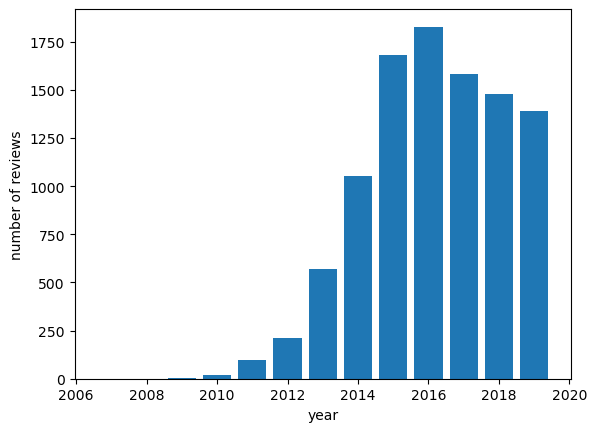

In [7]:
review_years_training_dataset = pd.to_datetime(df_train.timestamp, unit='ms').dt.year
plt.bar(*np.unique(review_years_training_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

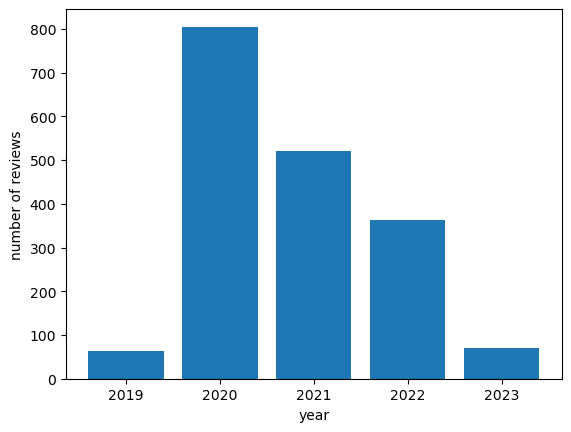

In [8]:
review_years_testing_dataset = pd.to_datetime(df_test.timestamp, unit='ms').dt.year
plt.bar(*np.unique(review_years_testing_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

It seems that the whole dataset was split based on the timestamp. No leaks of future info in the dataset. If there were leakage, that would mean that the system would learn the user's behaviour based on their future behaviour in order to estimate their past behaviour. Also using temporal split improves the measurement of generalization of the model.

In [9]:
avg_item_rating_training_dataset = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_training_dataset = avg_item_rating_training_dataset[avg_item_rating_training_dataset.avg_rating >= 3]
avg_high_rated_item_freq_training_dataset = avg_high_rated_item_training_dataset.shape[0]/avg_item_rating_training_dataset.shape[0]

avg_item_rating_test_dataset = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_test_dataset = avg_item_rating_test_dataset[avg_item_rating_test_dataset.avg_rating >= 3]
avg_high_rated_item_freq_test_dataset = avg_high_rated_item_test_dataset.shape[0]/avg_item_rating_test_dataset.shape[0]
print(f"Freq of high-rated reviews for items - train [{avg_high_rated_item_freq_training_dataset}], test [{avg_high_rated_item_freq_test_dataset}]")

Freq of high-rated reviews for items - train [1.0], test [0.9733656174334141]


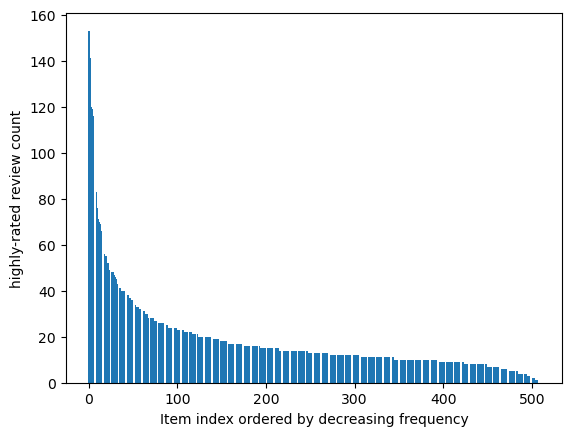

In [10]:
# High rates per musical instrument
df_train_high_ratings_count_per_item = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_train_high_ratings_count_per_item.shape[0]), height=df_train_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by decreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

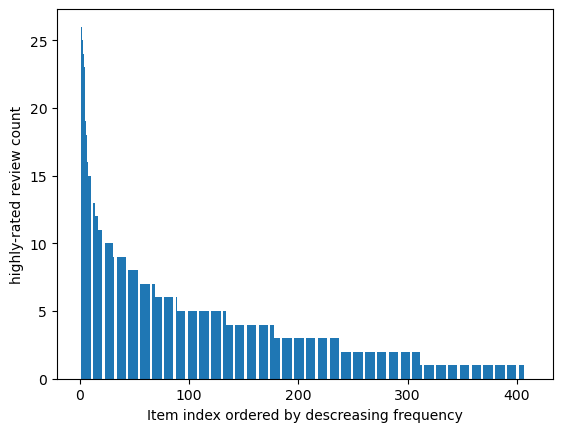

In [11]:
# High rates per musical instrument
df_test_high_ratings_count_per_item = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_test_high_ratings_count_per_item.shape[0]), height=df_test_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

In [12]:
print("Train dataset top 5 most highly rated items:")
print(avg_item_rating_training_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:5,:])

Train dataset top 5 most highly rated items:
        item_id  avg_rating  count
286  B07N2HQ1T7         5.0     28
254  B07C9YCY5J         5.0     14
31   B000U0DU34         5.0     13
473  B0BT2W3TTM         5.0     13
298  B07S19XSPV         5.0     12


In [13]:
print("Test dataset top 5 most highly rated items:")
print(avg_item_rating_test_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:5,:])

Test dataset top 5 most highly rated items:
        item_id  avg_rating  count
278  B09G5KLKX2         5.0     10
330  B0B8F6LD9F         5.0     10
365  B0BL8897K3         5.0      9
76   B00NPAMDQ6         5.0      8
186  B07CRK35NG         5.0      8


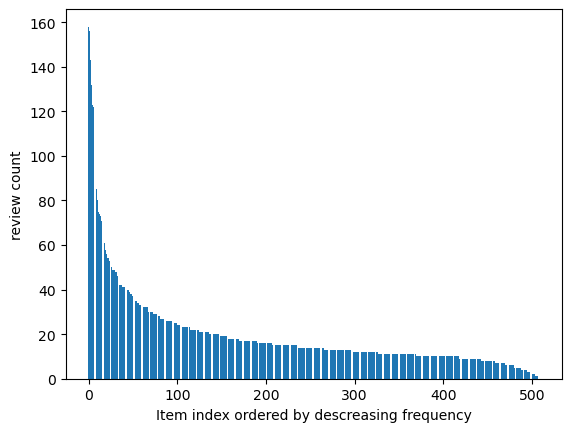

In [14]:
df_per_item_review_count_train_dataset = df_train.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_train_dataset.shape[0]), height=df_per_item_review_count_train_dataset.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("review count")
plt.show()

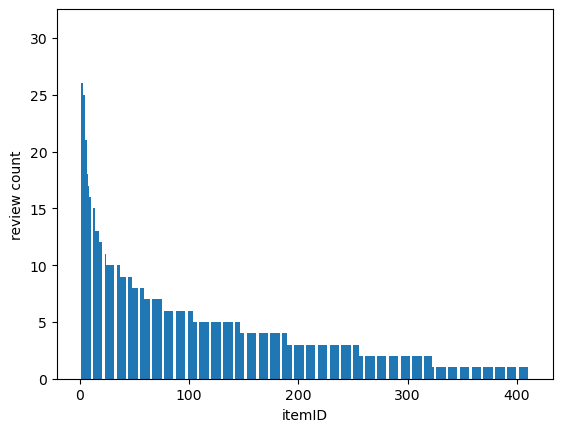

In [15]:
import matplotlib.pyplot as plt

df_per_item_review_count_test_dataset = df_test.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_test_dataset.shape[0]), height=df_per_item_review_count_test_dataset.iloc[:,1])
plt.xlabel("itemID")
plt.ylabel("review count")
plt.show()

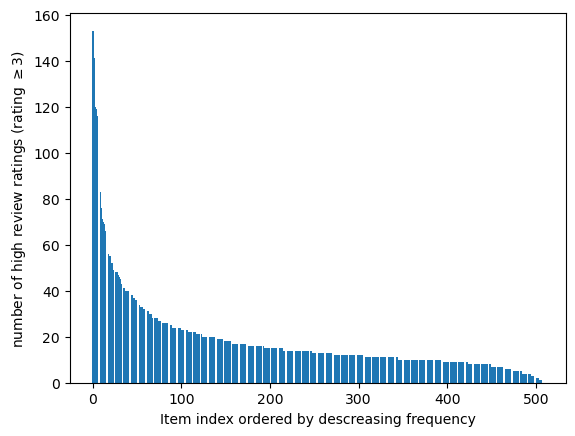

In [16]:
count_high_ratings_per_item_train = df_train[df_train["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_train.shape[0]), height=count_high_ratings_per_item_train)
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel(r"number of high review ratings (rating $\geq$3)")
plt.show()

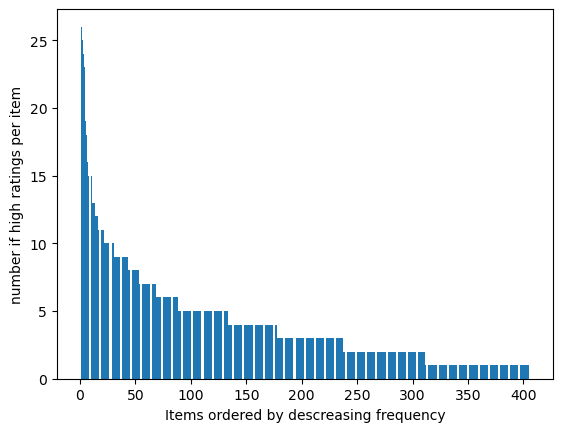

In [ ]:
count_high_ratings_per_item_test = df_test[df_test["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_test.shape[0]), height=count_high_ratings_per_item_test)
plt.xlabel("Items ordered by descreasing frequency")
plt.ylabel("number of high ratings per item")
plt.show()

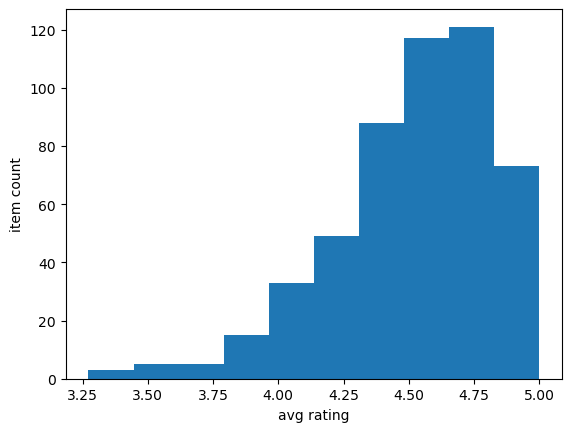

In [18]:
df_per_item_review_avg_rating_train_dataset = df_train.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_train_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.show()

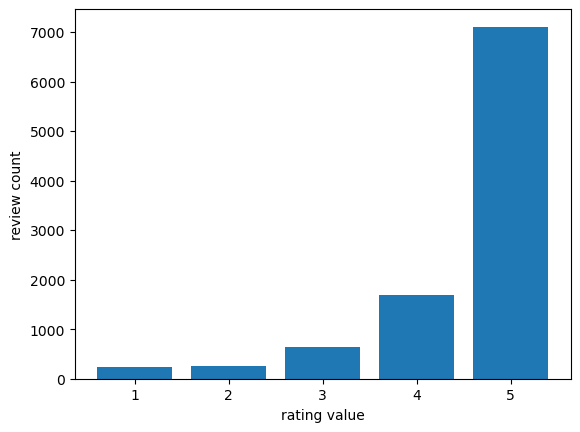

In [19]:
df_per_item_review_avg_rating_train_dataset = df_train["rating"]
plt.bar(*np.unique(df_train["rating"], return_counts=True))
plt.xlabel("rating value")
plt.ylabel("review count")
plt.show()

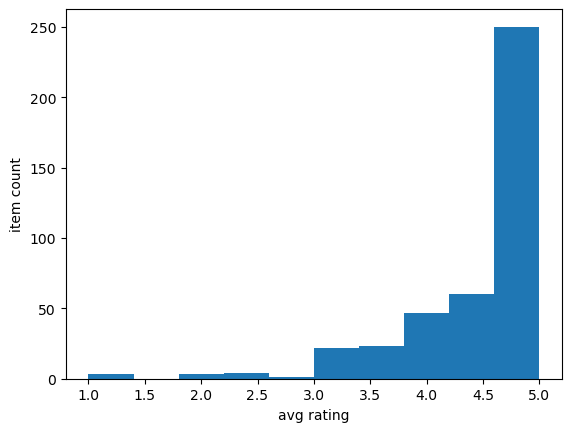

In [20]:
df_per_item_review_avg_rating_test_dataset = df_test.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_test_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.show()

The discrepancy between the distributions in the train and test dataset is concerning. Given that in the training dataset all of the ratings are >=3, this would mean that for unobserved items the system will predict ratings >=3. However, in reality the real rating might be lower than 3.

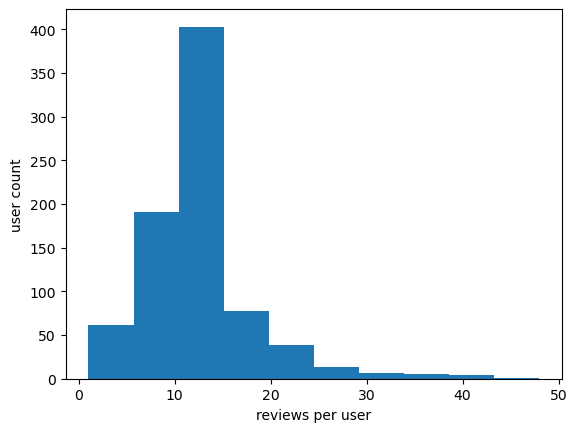

In [21]:
df_per_item_review_count_train_dataset = df_train.groupby("user_id").size()
plt.hist(df_per_item_review_count_train_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

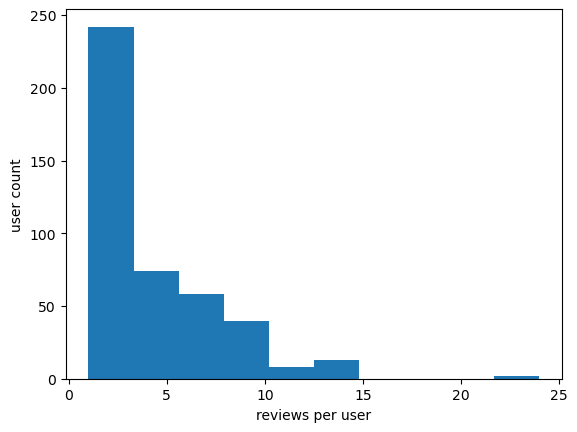

In [22]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.hist(df_per_item_review_count_test_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

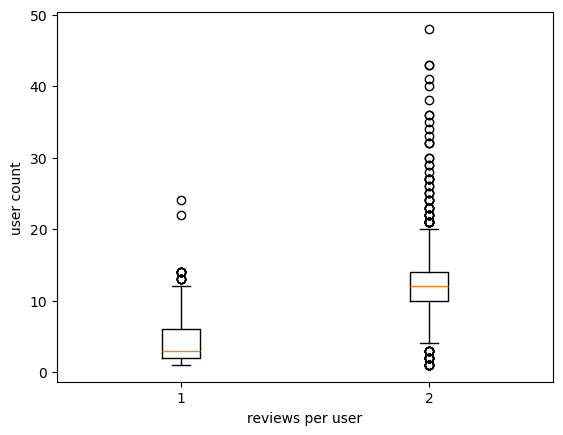

In [23]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.boxplot([df_per_item_review_count_test_dataset, df_per_item_review_count_train_dataset])
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

In [24]:
df_train.shape[0] + df_test.shape[0]

11735

In [27]:
df_train

,item_id,user_id,rating,timestamp
6582,B005M0MUQK,AE23LDQTB7L76AP6E6WPBFVYL5DA,4.0,1523727684523
7338,B007T8CUNG,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1538338679388
5709,B015IJIO5U,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1550441940530
8394,B09NLV5LBK,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565530500329
10866,B0BSR996X8,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565529596545
...,...,...,...,...
7095,B0928H8KFQ,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1567116669646
6145,B09396NY1C,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1507288252495
10394,B095XZJ99J,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,5.0,1551528681939
5962,B09QZJ57YW,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,4.0,1563049606419


In [6]:
# Data sparsity
unique_users_num = len(set(df_train.user_id.tolist()) | set(df_test.user_id.tolist()))
unique_items_num = len(set(df_train.item_id.tolist()) | set(df_test.item_id.tolist()))

print(f"Number of users {unique_users_num}")
print(f"Number of items {unique_items_num}")

num_test_dataset_user_not_in_training_dataset = len(set(df_test.user_id.tolist()).difference(set(df_train.user_id.tolist())))
print(f"Number of user in the test dataset that aren't present in the training dataset: {num_test_dataset_user_not_in_training_dataset}")

data_sparsity = 1.0 - (df_train.shape[0] + df_test.shape[0])/ (unique_users_num * unique_items_num)
print(f"Data sparsity is :{data_sparsity}")

Number of users 800
Number of items 518
Number of user in the test dataset that aren't present in the training dataset: 0
Data sparsity is :0.9716819498069498


So they \# users and \# items are relatively on the same order. So one cannot directly tell whether user-based or item-based is more appropriate. If users were orders of magnituded more than the items, then item-based would have been preferable

# Week 7

In [15]:
from surprise import Reader, KNNWithMeans, SVD, Dataset
from sklearn.metrics import root_mean_squared_error as rmse

In [16]:
reader = Reader(rating_scale=(1, 5))
training_matrix = Dataset.load_from_df(df_train[['user_id', 'item_id','rating']], reader)

In [7]:
from collections import defaultdict
from surprise.prediction_algorithms.predictions import Prediction
from typing import Dict, List

def get_recommendations_per_user(predictions: List[Prediction]) -> Dict[str, List]:
    """Order items from highest recommended to lowest recommended for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    pred_df = pd.DataFrame(predictions)
    recommendation_ordered_items = pred_df.groupby("uid", group_keys=False).apply(lambda group: group.sort_values("est", ascending=False)
                          .apply(lambda row: (row.iid, row.est), axis=1)
                          .tolist())
    return recommendation_ordered_items

def get_top_k(predictions: List[Prediction], 
              k: int) -> Dict[str, List]:
    """Compute the top-K recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        k(int): The number of recommendation to output for each user. If  k is -1, then no predictions are discarded.
    Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    
    def select_top_k_or_return_all(k):
        return lambda group: group.head(k) if k == -1 else group 
    
    topk = defaultdict(list)

    pred_df = pd.DataFrame(predictions)

    # Select top-k predictions per user
    filtered_pred_df = pred_df.sort_values(["uid", "est"], ascending=[True, False]) \
            .groupby("uid", group_keys=True, as_index=False) \
            .head(k)
            #.apply(select_top_k_or_return_all(k)) \
            #.reset_index(drop=True)

    # Convert to dictionary of lists
    topk = filtered_pred_df.groupby("uid")[["iid", "est"]].apply(lambda x: list(x.itertuples(index=False, name=None))).to_dict()

    return topk

In [8]:
arr = [1,2,3,4]
arr[:3]

[1, 2, 3]

In [38]:
import numpy as np
from __future__ import (absolute_import, division, print_function, unicode_literals)
from collections import defaultdict
from surprise import Dataset
from typing import Set, Tuple

def _convert_ratings_to_relevance(user: str, recommendations: List[Tuple[str,float]], df_test: pd.DataFrame) -> float:
    return [1  if ((df_test.user_id == user) & (df_test.item_id == iid) & (df_test.rating >=4)).any() else 0 for (iid, _) in recommendations]

def _get_num_relevant_items(user: str, dataset: pd.DataFrame) -> float:
    return dataset[(dataset.user_id == user) & (dataset.rating >= 4)].shape[0]

def precision_at_k(top_k_recommendations_per_user: Dict[str,List], 
                   df_test: pd.DataFrame,
                   k: int) -> Dict[str, float]:
    """Compute precision at k for each user
    Args:
        top_k_recommendations_per_user: Dictionary of top k recommendations for each test user.
        df_test: Pandas DataFrame containing user-item ratings in the test split.
        k: the expected size of each recommendation list
    Returns:
        The mean (float) of P@k for each user in "top_k_recommendations_per_user" dictionary
    """

    precisions = {}
    # First map the predictions to each user.
    
    top_k_recommended_items_relevance_per_user = { 
            user : _convert_ratings_to_relevance(user, recommendations[:k], df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
            if user in df_test.user_id.tolist()
        }

    # Write your code here
    precisions = [
        sum(top_k_recommended_items_relevance)/k 
        for top_k_recommended_items_relevance in top_k_recommended_items_relevance_per_user.values()
    ]
    
    return sum(precisions)/len(precisions) 


def mean_average_precision(top_k_recommendations_per_user:  Dict[str,List], 
                           df_test: pd.DataFrame,
                           k: int) -> float:
    """Compute the mean average precision 
    Args:
        top_k_recommendations_per_user: Dictionary of top k recommendations for each test user.
        df_test: Pandas DataFrame containing user-item ratings in the test split.
    Returns:
        The MAP@k (float)
    """

    average_precision_users = []
    # order all items in descending order with respect to predicted rating

    
    # map each recommendation to either 1 (if relevant) or 0 (not relevant)
    top_k_recommended_items_relevance_per_user = { 
            user : _convert_ratings_to_relevance(user, recommendations, df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
            if user in df_test.user_id.tolist()
        }
    
    for user, top_k_recommended_items_relevance in top_k_recommended_items_relevance_per_user.items():
        
       # num_relevant_items_for_user_in_test_dataset = df_test[(df_test.user_id == user) & (df_test.rating >= 4)].shape[0]
        
        num_relevant_items_for_user_in_test_dataset = _get_num_relevant_items(user, df_test)
        
        average_precision = 0
        for i in range(min(k, len(top_k_recommended_items_relevance))):
            if top_k_recommended_items_relevance[i] == 0.0:
                continue
            average_precision += sum(top_k_recommended_items_relevance[:i+1])/(i+1)
        
        if num_relevant_items_for_user_in_test_dataset > 0:
            average_precision /= min(k, num_relevant_items_for_user_in_test_dataset)
        else:
            average_precision /= k

        average_precision_users.append(average_precision)

    mapk = np.mean(average_precision_users)
    return mapk
    

def mean_reciprocal_rank(top_k_recommendations_per_user: Dict[str,List[Tuple[str,float]]], 
                         df_test: pd.DataFrame) -> float:
    """Compute the mean reciprocal rank 
    Args:
        top_k_recommendations_per_user: Dictionary of top k recommendations for each test user.
        df_test: Pandas DataFrame containing user-item ratings in the test split.
    Returns:
        The MRR@k (float)
    """    
    reciprocal_rank = []

    top_k_recommended_items_relevance_per_user = { 
            user : _convert_ratings_to_relevance(user, recommendations, df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
            if user in df_test.user_id.tolist()
        }
    
    for top_k_recommended_items_relevance in top_k_recommended_items_relevance_per_user.values():
        # some lists might not contain any relevant items. What we need to find is the first relevant item  
        reciprocal_rank.append(0.0)
        for i, relevance in enumerate(top_k_recommended_items_relevance):
            if relevance == 1:
                reciprocal_rank[-1] = (1.0/(i+1))
                break
    
    mean_rr =  np.mean(reciprocal_rank) if len(reciprocal_rank) > 0 else 0
    return mean_rr

def hit_rate(top_k: Dict[str, List[Tuple[str, float]]],
             df_test: pd.DataFrame) -> float:
    """Compute the hit rate
    Args:
        top_k: A dictionary where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n (output of get_top_k())
        df_test: Pandas DataFrame containing user-item ratings in 
            the test split.
    Returns:
        The average hit rate
    """
    hits = 0.0
    num_users = 0
    
    for user, recommended_items in top_k.items():
        if user not in df_test.user_id.tolist(): 
            continue
        num_users+=1
        
        top_k_recommended_items_relevance = _convert_ratings_to_relevance(user, recommended_items, df_test)
        if sum(top_k_recommended_items_relevance) > 0:
            hits += 1.0
    
    return hits/max(1,num_users)


def coverage(recommendation_ordered_items_per_user: Dict[str,List[Tuple[str, float]]], catalog_items: Set[str]):
    all_recommended_items = set(item for _, recommended_items in recommendation_ordered_items_per_user.items() for item, _ in recommended_items)
    all_recommended_items_from_the_catalog = all_recommended_items & catalog_items
    return len(all_recommended_items_from_the_catalog) * 1.0 / len(catalog_items)

## TopPop

In [17]:
import random
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)
num_folds = 5

In [18]:
class TopPopRecommender:
    def __init__(self, dataset_df):
        self.dataset_df = dataset_df
    
    def get_top_k_most_rated_highly_rated_items(self, k):
        return self.dataset_df[["item_id","rating"]]\
                .groupby("item_id", as_index=False)\
                .agg(high_ratings_count=("rating", lambda x: sum([1 if item >= 3.0 else 0 for item in x])), avg_rating=("rating","mean")) \
                .sort_values(["high_ratings_count", "avg_rating"], ascending=False) \
                .head(k)

In [19]:
df_train

,item_id,user_id,rating,timestamp
6582,B005M0MUQK,AE23LDQTB7L76AP6E6WPBFVYL5DA,4.0,1523727684523
7338,B007T8CUNG,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1538338679388
5709,B015IJIO5U,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1550441940530
8394,B09NLV5LBK,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565530500329
10866,B0BSR996X8,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565529596545
...,...,...,...,...
7095,B0928H8KFQ,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1567116669646
6145,B09396NY1C,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1507288252495
10394,B095XZJ99J,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,5.0,1551528681939
5962,B09QZJ57YW,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,4.0,1563049606419


Models chosen -> NeuMF, KNNWithMeans, Latent factor model + SVD + user bias + item bias, Graph based ->

In [14]:
rec = TopPopRecommender(df_train)
rec.get_top_k_most_rated_highly_rated_items(10)

,item_id,high_ratings_count,avg_rating
459,B0BPJ4Q6FJ,153,4.737179
470,B0BSGM6CQ9,153,4.689873
355,B09857JRP2,141,4.769231
433,B0BCK6L7S5,120,4.303030
483,B0BTC9YJ2W,119,4.737705
331,B08R5GM6YB,116,4.504065
431,B0B95V41NR,92,4.706522
48,B004XNK7AI,85,4.629213
332,B08SJY4T7K,84,4.200000
393,B09V91H5XM,83,4.647059


NameError: name 'Reader' is not defined

# SVD

In [34]:
from surprise.model_selection.search import GridSearchCV
param_grid = {
    "random_state" : [my_seed],
    "n_factors" : [2, 5, 10, 15, 20, 25, 30],
    "n_epochs": [10, 20, 50, 100, 1000, 5000]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse","mae"], cv=num_folds)
gs.fit(training_matrix)


KeyboardInterrupt: 

In [76]:
gs.best_score["rmse"]

0.8400634175115504

In [77]:
gs.best_params["rmse"]

{'random_state': 1234, 'n_factors': 2, 'n_epochs': 20}

# KNN

In [78]:
training_matrix

In [6]:
import math
math.sqrt(df_train.user_id.unique().size)

28.284271247461902

In [79]:
from surprise.model_selection.search import GridSearchCV
import math
param_grid = {
    "random_state" : [my_seed],
    "k" : list(range(1, math.ceil(math.sqrt(df_train.user_id.unique().size)), 1)),
    "sim_options": {
        "user_based": [True, False],
        "name": ["cosine", "pearson"]
    }
}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse","mae"], cv=num_folds)
gs.fit(training_matrix)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computi

In [80]:
gs.best_score["rmse"]

0.9053230375091628

In [81]:
gs.best_params["rmse"]

{'random_state': 1234,
 'k': 7,
 'sim_options': {'user_based': True, 'name': 'pearson'}}

Running each model with its best combination of hyperparameters

In [20]:
knn = KNNWithMeans(k=7,
                   sim_options={"name":"pearson","user_based":True},
                   verbose=False,
                   random_state=my_seed)

svd_lmf = SVD(n_factors=2, n_epochs=20, random_state=my_seed)
        

### Generating rating predictions on the unobserved user-item combinations

In [21]:
model_prediction = {}
models = {"knn": knn, "svd_lmf": svd_lmf}

for name, model in models.items():
    
    train_data = training_matrix.build_full_trainset()
    model.fit(train_data)

    unobserved_user_item_set = train_data.build_anti_testset()

    pred_KNN = model.test(unobserved_user_item_set) 
    df_pred_KNN = pd.DataFrame(pred_KNN)
    model_prediction[name] = df_pred_KNN

### Graph-based algorithm - Personalized Pagerank

In [ ]:
import numpy as np
import networkx as nx

# Prepare the data
def convert_data(df):
    df_convert = df[df.rating >= 4] #get the rows in the df where the rating is >3
    df_convert = df_convert[["item_id","user_id"]]
    df_convert_arr = df_convert.values
    return df_convert_arr

train_df = convert_data(df_train)

In [ ]:
''' Hyper Parameters '''
def parameter_dict_from_vector(vector):
    return {
        "W_USER_ITEM" : vector[0],
        "W_USER_ITEM_BACK" : vector[1]
        }

''' Building Graph '''
class InteractionGraph:
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        
    def add_nodes_from_edge_array(self, edge_array, type_1, type_2):
        nodes = [(x[0], {'type': type_1}) for x in edge_array] \
        + [(x[1], {'type': type_2}) for x in edge_array]
        self.graph.add_nodes_from(nodes)

    def add_edges_from_array(self, array, weight_front=1.0, weight_back=1.0):
        forward_edges = [(x[0], x[1], weight_front) for x in array]
        back_edges = [(x[1], x[0], weight_back) for x in array]
        self.graph.add_weighted_edges_from(forward_edges)
        self.graph.add_weighted_edges_from(back_edges)

def build_graph(parameter_dictionary, user_item_array):
    multigraph = InteractionGraph()
    multigraph.add_nodes_from_edge_array(user_item_array, 'item', 'user')
    multigraph.add_edges_from_array(user_item_array, 
                                    parameter_dictionary["W_USER_ITEM"], 
                                    parameter_dictionary["W_USER_ITEM_BACK"])
    return multigraph

class RecommendationEngine:
    def __init__(self, multigraph, damping_factor = 0.3):
        self.graph = nx.DiGraph()
        
        # if we have multple edges with the same source and destination, then create a single edge with the cummulative sum of those edges' weight
        for u,v,d in multigraph.graph.edges(data=True):
            w = d['weight']
            if self.graph.has_edge(u,v):
                self.graph[u][v]['weight'] += w
            else:
                self.graph.add_edge(u,v,weight=w)
        self.nodes = list(self.graph.nodes)
        self.damping_factor = damping_factor
        
        #this part keeps track of items that have been rated by each user in the training set
        self.user_item_dict = {}
        for n in multigraph.graph.nodes.data():
            if n[1]['type'] == 'user':
                self.user_item_dict[n[0]] = set()
        for e in multigraph.graph.edges:
            if e[0] in self.user_item_dict:
                self.user_item_dict[e[0]].add(e[1])

    def generate_pr(self, user, damping_factor):
        # Searching for the node corresponding to the user in the graph
        pers = [1 if n==user else 0 for n in self.nodes]
        pers_dict = dict(zip(self.nodes, pers))
        pr = nx.pagerank(self.graph, damping_factor, personalization=pers_dict)
        pr_sorted = dict(
            #sort pr by descending probability values
            sorted(pr.items(), key=lambda x: x[1], reverse=True)
            )
        pr_list = [(k, v) for k, v in pr_sorted.items()]
        return pr_list
    
    def generate_recommendations(self, user):
        pr_list = self.generate_pr(user,self.damping_factor)
        if user not in self.user_item_dict.keys():
            return pr_list
        
        result = [item for (item, _) in pr_list if item not in self.user_item_dict.keys() and item not in self.user_item_dict[user]]        
        #Given the user, remove items in their recommendation list that they have rated in the training set
        #hint: you can use user_item_dict for this
        return result

In [ ]:
import sklearn.model_selection as ms

K=10
damping_factor_options = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]

results = {}
for damping_factor in damping_factor_options:
    print(damping_factor)
    kf = ms.KFold(n_splits=num_folds, shuffle=True, random_state=my_seed)
    total_map = 0.0
    
    for train_indeces, test_indeces in kf.split(df_train):

        # train and test algorithm.
        trainset = df_train.iloc[train_indeces]
        testset = df_train.iloc[test_indeces]

        graph = build_graph(parameter_dict_from_vector(np.ones(2)), convert_data(trainset))
        recommender = RecommendationEngine(graph, damping_factor)
        graph_model_recommendations_per_user = {user: recommender.generate_recommendations(user)[:K] for user in testset.user_id.unique().tolist()}
        
        top_k_list = {user: list(zip(recommendations, [0]*len(recommendations))) for user, recommendations in graph_model_recommendations_per_user.items()}
        
        total_map += mean_average_precision(top_k_list,testset,  K)
        
    results[damping_factor]=total_map / num_folds

In [ ]:
results

In [ ]:
damping_factor = 0.50
K = 10
train_data = training_matrix.build_full_trainset()
unobserved_user_item_set = train_data.build_anti_testset()

graph = build_graph(parameter_dict_from_vector(np.ones(2)), train_df)
recommender = RecommendationEngine(graph, damping_factor)

graph_model_recommendations_per_user = {user: recommender.generate_recommendations(user)[:K] for user in df_train.user_id.unique().tolist()}
personalized_pagerank_top_k_list = {user: list(zip(recommendations, [0]*len(recommendations))) for user, recommendations in graph_model_recommendations_per_user.items()}

In [ ]:
top_k_list

# Week 8

In [22]:
def evaluate_recommendation_performance(top_k_recommendations_per_user, df_train, df_test, k=10):
    # PRECISION
    precision_nb = precision_at_k(top_k_recommendations_per_user, df_test, k=k)
    print("Precision@{}: {:.3f}".format(k, precision_nb))
    # MAP 
    map_nb = mean_average_precision(top_k_recommendations_per_user, df_test, k=k)
    print("MAP@{}: {:.3f}".format(k,map_nb))
    # MRR
    mrr_nb = mean_reciprocal_rank(top_k_recommendations_per_user, df_test)
    print("MRR@{}: {:.3f}".format(k,mrr_nb))
    # HIT Rate
    print("Hit Rate top-{}: {:.3f}".format(k,hit_rate(top_k_recommendations_per_user, df_test)))
    # Coverage
    #coverage_k = coverage(top_k_recommendations_per_user, len(set(df_train.item_id.tolist() + df_test.item_id.tolist())))
    coverage_k = coverage(top_k_recommendations_per_user, set(df_train.item_id.tolist() + df_test.item_id.tolist()))
    print("Coverage@{}: {:.3f}".format(k,coverage_k))

In [23]:
def evaluate_rating_prediction_performance(model_prediction, df_test):
    merged_df = pd.merge(model_prediction, df_test, how='inner', right_on=["item_id", "user_id"], left_on=["iid", "uid"])
    return rmse(merged_df.rating, merged_df.est)

## Utility-based metrics

In [197]:
model_prediction["svd_lmf"]

,uid,iid,r_ui,est,details
0,AE23LDQTB7L76AP6E6WPBFVYL5DA,B000NGVQKO,4.532029,4.364850,{'was_impossible': False}
1,AE23LDQTB7L76AP6E6WPBFVYL5DA,B005PGGU9O,4.532029,4.394865,{'was_impossible': False}
2,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00CPLODUU,4.532029,4.702008,{'was_impossible': False}
3,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00RX5HQS4,4.532029,4.919572,{'was_impossible': False}
4,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00VSYN25M,4.532029,4.403270,{'was_impossible': False}
...,...,...,...,...,...
397282,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B07KRZ1HH8,4.532029,3.950756,{'was_impossible': False}
397283,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B08PBNXZYP,4.532029,3.950386,{'was_impossible': False}
397284,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B073RTT48C,4.532029,3.969423,{'was_impossible': False}
397285,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B0BNCDVD4M,4.532029,3.866012,{'was_impossible': False}


In [24]:
evaluate_rating_prediction_performance(model_prediction["svd_lmf"], df_test)

0.9717974345148909

In [25]:
evaluate_rating_prediction_performance(model_prediction["knn"], df_test)

1.0407291920915884

## Rank-based metrics

In [26]:
svd_top_k_recommendations_per_user = get_top_k(model_prediction["svd_lmf"], 10)
evaluate_recommendation_performance(svd_top_k_recommendations_per_user, df_train, df_test, 10)

Precision@10: 0.010
MAP@10: 0.006
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MRR@10: 0.025
Hit Rate top-10: 0.092
Coverage@10: 0.102


In [27]:
knn_top_k_recommendations_per_user = get_top_k(model_prediction["knn"], 10)
evaluate_recommendation_performance(knn_top_k_recommendations_per_user, df_train, df_test)

Precision@10: 0.012
MAP@10: 0.010
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MRR@10: 0.034
Hit Rate top-10: 0.105
Coverage@10: 0.807


In [29]:

rec = TopPopRecommender(df_train)
top_k_list = rec.get_top_k_most_rated_highly_rated_items(10).item_id.tolist()
top_k_list = [(item, 0) for item in top_k_list]

toppop_top_k_recommendations_per_user = {user: top_k_list for user in df_train.user_id.unique().tolist()}
evaluate_recommendation_performance(toppop_top_k_recommendations_per_user, df_train, df_test)

Precision@10: 0.031
MAP@10: 0.032
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MRR@10: 0.112
Hit Rate top-10: 0.243
Coverage@10: 0.019


## Analysis on the effect of the long-tail

In [43]:
df_train_users_sorted_by_review_count = df_train.groupby("user_id").agg(count=("rating","size")).sort_values(by='count', ascending=False)
top_20_perc_users_with_highest_review_count = df_train_users_sorted_by_review_count[:int(df_train_users_sorted_by_review_count.shape[0] * 0.20)].index.to_list()
last_20_perc_users_with_highest_review_count = df_train_users_sorted_by_review_count[-int(df_train_users_sorted_by_review_count.shape[0] * 0.20):].index.to_list()

In [44]:
df_train_items_sorted_by_review_count = df_train.groupby("item_id").agg(count=("rating","size")).sort_values(by='count', ascending=False)
top_20_perc_items_with_highest_review_count = df_train_items_sorted_by_review_count[:int(df_train_items_sorted_by_review_count.shape[0] * 0.20)].index.to_list()
last_20_perc_items_with_highest_review_count = df_train_items_sorted_by_review_count[-int(df_train_items_sorted_by_review_count.shape[0] * 0.20):].index.to_list()

In [45]:
def analyze_effect_of_long_tail(top_k_recommendations_per_user_given_model, top_20_perc_users, bottom_20_perc_users, top_20_perc_items, bottom_20_prec_items, df_test):
    top_k_recommendations_per_top_20_perc_user = {user: top_k_recommendations_per_user_given_model[user] for user in top_20_perc_users}
    top_k_recommendations_per_bottom_20_perc_user = {user: top_k_recommendations_per_user_given_model[user] for user in bottom_20_perc_users}
    
    print("Hit Rate top-{}: {:.3f}".format(10,hit_rate(top_k_recommendations_per_top_20_perc_user, df_test)))
    print("Hit Rate top-{}: {:.3f}".format(10,hit_rate(top_k_recommendations_per_bottom_20_perc_user, df_test)))
    
    coverage_k = coverage(top_k_recommendations_per_user_given_model, set(top_20_perc_items))
    print(f"Coverage@{10} is {coverage_k}")
    
    coverage_k = coverage(top_k_recommendations_per_user_given_model, set(bottom_20_prec_items))
    print(f"Coverage@{10} is {coverage_k}")

In [46]:
analyze_effect_of_long_tail(
    knn_top_k_recommendations_per_user,
    top_20_perc_users_with_highest_review_count,
    last_20_perc_users_with_highest_review_count,
    top_20_perc_items_with_highest_review_count,
    last_20_perc_items_with_highest_review_count,
    df_test
)

Hit Rate top-10: 0.050
Hit Rate top-10: 0.163
Coverage@10 is 0.9900990099009901
Coverage@10 is 0.5643564356435643


In [47]:
analyze_effect_of_long_tail(
    svd_top_k_recommendations_per_user,
    top_20_perc_users_with_highest_review_count,
    last_20_perc_users_with_highest_review_count,
    top_20_perc_items_with_highest_review_count,
    last_20_perc_items_with_highest_review_count,
    df_test
)

Hit Rate top-10: 0.083
Hit Rate top-10: 0.156
Coverage@10 is 0.15841584158415842
Coverage@10 is 0.039603960396039604


In [48]:
analyze_effect_of_long_tail(
    toppop_top_k_recommendations_per_user,
    top_20_perc_users_with_highest_review_count,
    last_20_perc_users_with_highest_review_count,
    top_20_perc_items_with_highest_review_count,
    last_20_perc_items_with_highest_review_count,
    df_test
)

Hit Rate top-10: 0.133
Hit Rate top-10: 0.375
Coverage@10 is 0.09900990099009901
Coverage@10 is 0.0


## Error analysis for the neighbourhood-based CF

In [30]:
# use all recommendations instead of the top k ones
knn_recommendations_per_user = get_top_k(model_prediction["knn"], df_train.shape[0])

In [36]:
df_train[(df_train.user_id == 'AHQMEESXZDL2LPUFFMO7DDAXMMJA') & (df_train.item_id == 'B01DBS2U9G')]

,item_id,user_id,rating,timestamp
6196,B01DBS2U9G,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1462902549000


In [31]:
knn_recommendations_per_user['AHQMEESXZDL2LPUFFMO7DDAXMMJA']

[('B088DD5M4V', 5.0),
 ('B09M7F7LFB', 4.951515151515152),
 ('B0B3VSZQHL', 4.951515151515152),
 ('B09198262S', 4.951515151515152),
 ('B0B8Z2T4PS', 4.951515151515152),
 ('B0817CVBLV', 4.847619047619048),
 ('B015X3CXXA', 4.847619047619048),
 ('B0B8M5FJB6', 4.847619047619048),
 ('B000BYPJ1U', 4.847619047619048),
 ('B0002D0Q2W', 4.839754615373094),
 ('B012VQ5A7S', 4.833333333333334),
 ('B004OK1G64', 4.833333333333334),
 ('B073T2YK2J', 4.833333333333334),
 ('B081592T7F', 4.833333333333334),
 ('B079NS31NK', 4.780672026175973),
 ('B0C6H9T5T6', 4.76969696969697),
 ('B00BESRB8Q', 4.758333333333334),
 ('B01DE4DVO0', 4.758333333333334),
 ('B07L6RCDP7', 4.758333333333334),
 ('B00VOQQDHI', 4.758333333333334),
 ('B01LL8PRIY', 4.758333333333334),
 ('B0BPJ4Q6FJ', 4.738153729412702),
 ('B0BPKH4HB2', 4.733333333333333),
 ('B0928H8KFQ', 4.733333333333333),
 ('B07849RG3X', 4.733333333333333),
 ('B004XNK7AI', 4.70696882696401),
 ('B09BF8XDF4', 4.699265284199131),
 ('B0C5LYJXLR', 4.676396048300199),
 ('B08JM

In [86]:
rr_for_user = {user : mean_reciprocal_rank({user: recommendations}, df_test) for user, recommendations in knn_recommendations_per_user.items() if user in df_test.user_id.tolist()}

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [53]:
sorted_rr_per_user = sorted(rr_for_user.items(), key=lambda x: x[1], reverse=True)

In [54]:
sorted_rr_per_user

[('AEMSFZ4NLED647BP3ZCQEY3FNGKA', 1.0),
 ('AENNORCDOTT2KFT5WUIK7PJ2EXOA', 1.0),
 ('AF2MGAQBAT3E4XQC7NNAQFYG4MIQ', 1.0),
 ('AGUTAG6UMQ2W2HNDV7ZH2HDP7M4A', 1.0),
 ('AH5QT754LOCVVNX2QBP2QCHFPO6Q', 1.0),
 ('AEW3WN45BO5QRGK3RPQ2DREV4NGA', 0.5),
 ('AFQRADPBJBT3FQPLY3DLXYDZYNFQ', 0.5),
 ('AGTQ4C5UOLPC6RNAX573O2TU5S3Q', 0.5),
 ('AH44K3RPIQMVWG2G4EB5FPVIVUEQ', 0.5),
 ('AHOUKQ3IRAEAMEHDB6U4AMB366NQ', 0.5),
 ('AHP54DEEFACVFPIFX7KZ3P32ZYVQ', 0.5),
 ('AE6R5VSHXSCOZJBEJY7BCRM7A6OQ', 0.3333333333333333),
 ('AFR6WKFQBTKBG7HH7MOIHP7Y4IJQ', 0.3333333333333333),
 ('AGOFGZANYMUDHB2NTVTOW63TG2RA', 0.3333333333333333),
 ('AHGODYYGTJFO5RXGWPSKFVXS25PQ', 0.3333333333333333),
 ('AFDZU5HCDZTKTC6LL2KI5DQHQ2IA', 0.25),
 ('AG4VWLJ2X7PIBYDXYYUNFY5ONDRQ', 0.25),
 ('AGR2HGNGBX6TFVFHQFKXRPP4B22Q', 0.25),
 ('AHMUAUOHLITDKIKI4C3KVRWIBMAQ', 0.25),
 ('AE3TS5R65QSFTYKTSRHFXQKVR5IQ', 0.2),
 ('AEATZO22KZMV7ECXWBK5KSURDZAA', 0.2),
 ('AENF7IROS6474V6TOKAONGVZHMVQ', 0.2),
 ('AETS7HNSQIFRSMRCWQMHIWZ2IBOQ', 0.2),
 ('AF4VYLI2QY2N7

In [59]:
sorted_rr_per_user[0]

('AEMSFZ4NLED647BP3ZCQEY3FNGKA', 1.0)

In [60]:
sorted_rr_per_user[-1]

('AHQMEESXZDL2LPUFFMO7DDAXMMJA', 0.0)

In [76]:
inner_uid_closest_neighbours = knn.get_neighbors(knn.trainset.to_inner_uid('AEMSFZ4NLED647BP3ZCQEY3FNGKA'), k=10)
closest_nighbours_to_top_rr_user = []
for inner_uid in inner_uid_closest_neighbours:
    closest_nighbours_to_top_rr_user.append(knn.trainset.to_raw_uid(inner_uid))

In [77]:
closest_nighbours_to_top_rr_user

['AGANKYJ6D2VIOOGVEFFWZRBSHLLA',
 'AE23LDQTB7L76AP6E6WPBFVYL5DA',
 'AE23ZFVUOMPKR57BVSWXV34QLMVA',
 'AE2BV2H57ERXAPW7SOAXFLWA2S2Q',
 'AE2EQIUBKQCVSP55MNF2SQIASN2Q',
 'AE2NWSTL7JJJWOCBKZCZF6KDQIZQ',
 'AE2OQ55HLV5XO54DWLE4PB5XUNPA',
 'AE2TQUALUTZLMEWBULG5K65EOQSQ',
 'AE2W7OBJ45J4J52CGH7OFWHQZJQA',
 'AE37RAW77LNOTEDKMDKGXSGQHD5Q']

In [78]:
df_train[df_train.user_id.isin(closest_nighbours_to_top_rr_user)] \
    .groupby(by='user_id') \
    .agg(
        count=("rating","size"),
        max_rating=("rating","max"),
        min_rating=("rating","min"),
        avg_rating=("rating","mean"),
        median_rating=("rating", "median")
    )

,count,max_rating,min_rating,avg_rating,median_rating
user_id,,,,,
AE23LDQTB7L76AP6E6WPBFVYL5DA,5,5.0,4.0,4.800000,5.0
AE23ZFVUOMPKR57BVSWXV34QLMVA,18,5.0,3.0,4.555556,5.0
AE2BV2H57ERXAPW7SOAXFLWA2S2Q,10,5.0,1.0,3.900000,5.0
AE2EQIUBKQCVSP55MNF2SQIASN2Q,11,5.0,1.0,4.636364,5.0
AE2NWSTL7JJJWOCBKZCZF6KDQIZQ,3,5.0,4.0,4.666667,5.0
AE2OQ55HLV5XO54DWLE4PB5XUNPA,11,5.0,4.0,4.818182,5.0
AE2TQUALUTZLMEWBULG5K65EOQSQ,14,5.0,4.0,4.857143,5.0
AE2W7OBJ45J4J52CGH7OFWHQZJQA,14,5.0,3.0,4.785714,5.0
AE37RAW77LNOTEDKMDKGXSGQHD5Q,17,5.0,3.0,4.764706,5.0


In [71]:
rated_items = df_train[df_train.user_id == 'AEMSFZ4NLED647BP3ZCQEY3FNGKA'].item_id.tolist()
for user_id in closest_nighbours_to_top_rr_user:
    common_items = df_train[(df_train.user_id == user_id) & (df_train.item_id.isin(rated_items))].item_id.tolist()
    print(f"Common items between \"AEMSFZ4NLED647BP3ZCQEY3FNGKA\" and {user_id} are: ")
    for item in common_items:
        curr_user_rating = df_train[(df_train.user_id == 'AEMSFZ4NLED647BP3ZCQEY3FNGKA') & (df_train.item_id == item)].rating.tolist()[0]
        neighbour_rating = df_train[(df_train.user_id == user_id) & (df_train.item_id == item)].rating.tolist()[0]
        print(f"    {item}:{curr_user_rating} vs {neighbour_rating}")
        
    print(df_train[df_train.item_id.isin(common_items)].groupby(by='item_id').agg(count=("rating","size"),avg_rating=("rating","mean")))
   

Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AFGFKPFXJEVFESVOZR7E6OE4KSRQ are: 
Empty DataFrame
Columns: [count, avg_rating]
Index: []
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AEPGWR4J3CQI76JJVCCOQQJEH2CA are: 
    B08T2DMFKD:5.0 vs 4.0
            count  avg_rating
item_id                      
B08T2DMFKD     12        4.75
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AE23LDQTB7L76AP6E6WPBFVYL5DA are: 
Empty DataFrame
Columns: [count, avg_rating]
Index: []
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AE23ZFVUOMPKR57BVSWXV34QLMVA are: 
Empty DataFrame
Columns: [count, avg_rating]
Index: []
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AE2BV2H57ERXAPW7SOAXFLWA2S2Q are: 
Empty DataFrame
Columns: [count, avg_rating]
Index: []
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AE2EQIUBKQCVSP55MNF2SQIASN2Q are: 
Empty DataFrame
Columns: [count, avg_rating]
Index: []
Common items between "AEMSFZ4NLED647BP3ZCQEY3FNGKA" and AE2NWST

In [79]:
inner_uid_closest_neighbours = knn.get_neighbors(knn.trainset.to_inner_uid('AHQMEESXZDL2LPUFFMO7DDAXMMJA'), k=10)
closest_nighbours_to_bottom_rr_user = []
for inner_uid in inner_uid_closest_neighbours:
    closest_nighbours_to_bottom_rr_user.append(knn.trainset.to_raw_uid(inner_uid))


In [80]:
closest_nighbours_to_bottom_rr_user

['AEHGPRL2ZLF6TY6JWBNFJNIDTE6Q',
 'AEIRBLA7WN4R3DFFWOUBDY6UYWEA',
 'AER5I36DVGSOMSGX3ZQHYZGPESFA',
 'AEVB5BSDA5OASLEFI37PGC2XHIIA',
 'AF2TXYUSL64QAUAGQ5H54JHCGSKA',
 'AFNOO5CWS6FB4PMBONLYRO5R6XGQ',
 'AH55IBNS32OBFM37T2AUX4JR5P6Q',
 'AF6XSSXRXNKEBD7X2H6LY2247BCQ',
 'AE23ZFVUOMPKR57BVSWXV34QLMVA',
 'AGJ4GTDNTPHMRM26V46EYAF7IGCA']

In [81]:
df_train[df_train.user_id.isin(closest_nighbours_to_bottom_rr_user)] \
    .groupby(by='user_id') \
    .agg(
        count=("rating","size"),
        max_rating=("rating","max"),
        min_rating=("rating","min"),
        avg_rating=("rating","mean"),
        median_rating=("rating", "median")
    )

,count,max_rating,min_rating,avg_rating,median_rating
user_id,,,,,
AE23ZFVUOMPKR57BVSWXV34QLMVA,18,5.0,3.0,4.555556,5.0
AEHGPRL2ZLF6TY6JWBNFJNIDTE6Q,9,5.0,1.0,3.000000,3.0
AEIRBLA7WN4R3DFFWOUBDY6UYWEA,14,5.0,3.0,4.714286,5.0
AER5I36DVGSOMSGX3ZQHYZGPESFA,8,5.0,4.0,4.750000,5.0
AEVB5BSDA5OASLEFI37PGC2XHIIA,10,5.0,3.0,4.700000,5.0
AF2TXYUSL64QAUAGQ5H54JHCGSKA,21,5.0,4.0,4.619048,5.0
AF6XSSXRXNKEBD7X2H6LY2247BCQ,11,5.0,2.0,4.363636,5.0
AFNOO5CWS6FB4PMBONLYRO5R6XGQ,15,5.0,1.0,4.400000,5.0
AGJ4GTDNTPHMRM26V46EYAF7IGCA,19,5.0,4.0,4.842105,5.0


In [82]:
rated_items = df_train[df_train.user_id == 'AHQMEESXZDL2LPUFFMO7DDAXMMJA'].item_id.tolist()
for user_id in closest_nighbours_to_bottom_rr_user:
    common_items = df_train[(df_train.user_id == user_id) & (df_train.item_id.isin(rated_items))].item_id.tolist()
    print(f"Common items between \"AHQMEESXZDL2LPUFFMO7DDAXMMJA\" and {user_id} are: ")
    for item in common_items:
        curr_user_rating = df_train[(df_train.user_id == 'AHQMEESXZDL2LPUFFMO7DDAXMMJA') & (df_train.item_id == item)].rating.tolist()[0]
        neighbour_rating = df_train[(df_train.user_id == user_id) & (df_train.item_id == item)].rating.tolist()[0]
        print(f"    {item}:{curr_user_rating} vs {neighbour_rating}")
        
    print(df_train[df_train.item_id.isin(common_items)].groupby(by='item_id').agg(count=("rating","size"),avg_rating=("rating","mean")))
   

Common items between "AHQMEESXZDL2LPUFFMO7DDAXMMJA" and AEHGPRL2ZLF6TY6JWBNFJNIDTE6Q are: 
    B01DBS2U9G:5.0 vs 5.0
    B08R5GM6YB:4.0 vs 1.0
            count  avg_rating
item_id                      
B01DBS2U9G     11    4.909091
B08R5GM6YB    123    4.504065
Common items between "AHQMEESXZDL2LPUFFMO7DDAXMMJA" and AEIRBLA7WN4R3DFFWOUBDY6UYWEA are: 
    B08R5GM6YB:4.0 vs 4.0
    B09RJZSQML:5.0 vs 5.0
            count  avg_rating
item_id                      
B08R5GM6YB    123    4.504065
B09RJZSQML     54    4.648148
Common items between "AHQMEESXZDL2LPUFFMO7DDAXMMJA" and AER5I36DVGSOMSGX3ZQHYZGPESFA are: 
    B08DM9NFLH:5.0 vs 5.0
    B08R5GM6YB:4.0 vs 4.0
            count  avg_rating
item_id                      
B08DM9NFLH     26    4.807692
B08R5GM6YB    123    4.504065
Common items between "AHQMEESXZDL2LPUFFMO7DDAXMMJA" and AEVB5BSDA5OASLEFI37PGC2XHIIA are: 
    B0BG95DG2H:5.0 vs 5.0
    B0BPLFP5P6:1.0 vs 3.0
            count  avg_rating
item_id                      
B0BG95DG

For the user with big RR score, with most of his top 10 neighbours (according to training dataset) he has no common items. On the other hand, for the user with worst RR score, with most of his top 10 neighbours (according to training dataset) he has at least 2 common items.

What causes this problem?
One problem of using cosine similarity is that it doesn't take into account the number of common items (non zero). This leads to users, which have very few common items, categorized as close neighbours, due to taking into consideration all users, instead of filtering out those that have very few or no common items with the target user.

Now why does the person with the higher RR, have zero common items with his neighbours and still have a good RR score? There is a simple answer to that - if the person hasn't rated a popular item yet, then he will be recommended that item. Moreover, when calculating RR, we just care about the position of the first relevant item - which will be the popular item.

Ok, but why the person with the lowest RR has 0 score?

In [39]:
df_train[df_train.user_id == 'AHQMEESXZDL2LPUFFMO7DDAXMMJA']

,item_id,user_id,rating,timestamp
4576,B00CGFRJ2Y,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1399405960000
6559,B00H4PEMM6,AHQMEESXZDL2LPUFFMO7DDAXMMJA,3.0,1399405037000
2053,B00IJ23YS6,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1409681062000
10831,B01AH3RSAO,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1409680129000
6196,B01DBS2U9G,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1462902549000
6024,B01DZ6FBBI,AHQMEESXZDL2LPUFFMO7DDAXMMJA,3.0,1472594465000
8629,B074WXM13T,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1396649532000
9328,B07XP6MHQT,AHQMEESXZDL2LPUFFMO7DDAXMMJA,1.0,1396649457000
7356,B08DM9NFLH,AHQMEESXZDL2LPUFFMO7DDAXMMJA,5.0,1399405569000
700,B08R5GM6YB,AHQMEESXZDL2LPUFFMO7DDAXMMJA,4.0,1396649743000


# Week 9

## Metadata.tsv contains 2 items without titles and 6423 items without description

In [ ]:
# some items might not have 
item_metadata = pd.read_csv("metadata.tsv", sep="\t")

In [88]:
item_metadata.shape

(23984, 3)

In [115]:
all_rated_items_set = set(df_train.item_id.tolist() + df_test.item_id.tolist())

# Discard items that weren't rated by our subset of users
filtered_item_metadata = item_metadata[item_metadata.item_id.isin(all_rated_items_set) & item_metadata.description.notna()].drop_duplicates(['item_id', 'description'])
item_descriptions = filtered_item_metadata.description.tolist()
item_id_and_description = list(filtered_item_metadata[["item_id", "description"]].itertuples(index=False, name=None))

why using only metadata for the items in the train/test dataset

In [116]:
filtered_item_metadata.shape

(421, 3)

In [117]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string

corpus =  " ".join([item_descr for item_descr in filtered_item_metadata.description.tolist()])
tokenized_corpus = word_tokenize(corpus, language="english")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
len(set(tokenized_corpus))

7229

In [119]:
stopwords = []
# source http://members.unine.ch/jacques.savoy/clef/ -> english stop words
with open("stopwords.txt", "r") as stopwords_dataset_file:
    lines = stopwords_dataset_file.readlines()
    for l in lines:
        # Remove the new line symbol from each word
        stopwords.append(l.removesuffix('\n'))

In [120]:
len(stopwords)

571

In [121]:
stemmer = PorterStemmer()
stemmed_tokenized_corpus = [stemmer.stem(token) for token in tokenized_corpus]
stops_words_english = set(stopwords + list(string.punctuation)) 
corpus_filtered_tokens = set([token for token in stemmed_tokenized_corpus if token not in stops_words_english])

In [99]:
len(corpus_filtered_tokens)

4415

In [100]:
def preprocessing(text):
    lower_case_corpus = text.lower()
    tokenized_corpus = word_tokenize(lower_case_corpus)
    stemmer = PorterStemmer()
    stemmed_tokenized_corpus = [stemmer.stem(token) for token in tokenized_corpus]
    stops_words_english = set(stopwords) | set(string.punctuation)
    return " ".join([token for token in stemmed_tokenized_corpus if token not in stops_words_english])

In [ ]:
processed_descriptions = [preprocessing(description) for description in item_descriptions]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=corpus_filtered_tokens, tokenizer=lambda x: x.split(' '), token_pattern=None)
X = vectorizer.fit_transform(processed_descriptions)

# (84, 471) is interpreted as for each document we have entry for each word from our vocab. Each entry uses the tf-idf formula for the calculating of the significance of each word.

In [105]:
X.shape

(421, 4415)

### Word2Vec

In [110]:
# No stemming
def preprocessing(text):
    lower_case_corpus = text.lower()
    tokenized_corpus = word_tokenize(lower_case_corpus)
    stops_words_english = set(stopwords) | set(string.punctuation)
    return " ".join([token for token in tokenized_corpus if token not in stops_words_english])

processed_descriptions = [(item, preprocessing(description)) for item, description in item_id_and_description]


In [111]:
processed_descriptions

[('B0B8M5FJ9W',
  "product description patented design planet lock system fits virtually guitar stays locked place release side pin unlike ordinary strap lock systems planet lock designed fit securely guitar 's existing end pins change hardware guitar strap guitars safe secure easy planet waves patented planet lock system fits virtually guitar stays locked place release side pin unlike ordinary strap lock systems planet lock designed fit securely guitar 's existing end pins eliminating change hardware guitar strap guitars planet lock safe secure easy designed players genres planet waves woven straps offer designs discerning player iconic themes unique patterns artwork durable straps accent guitar adjustable 35 '' 59.5 '' long.planet waves part d'addario family brands innovative problem-solving quality musical accessories planet waves offers complete line award-winning accessories including cables picks tuners capos straps humidifiers maintenance tools .. manufacturer planet waves paten

In [112]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [113]:
# Represent items in the vector space by taking an average of the word embedding of the tokens in the item title
# Tokens that are (out-of-vocabulary) OOV may be skipped


description_to_embedding = {}
for item, descrition in processed_descriptions:
    in_vocab_words = 0
    sentence_embedding = np.zeros((300,))
    for word in descrition.split(" "):
        if word not in word2vec_vectors.key_to_index:
            continue
        sentence_embedding += word2vec_vectors[word]
        in_vocab_words+=1
    
    sentence_embedding /= max(in_vocab_words,1)
    description_to_embedding[item] = sentence_embedding

In [114]:
description_to_embedding

{'B0B8M5FJ9W': array([-0.01074533,  0.02720883, -0.03633271,  0.0653209 , -0.08440611,
         0.01099728,  0.04832802, -0.07170214,  0.08831579,  0.02530442,
        -0.05253857, -0.11630877,  0.01816414,  0.01107963, -0.050598  ,
         0.05189204,  0.03657882,  0.1199197 , -0.00237869, -0.04129685,
         0.03215545,  0.09919293, -0.06793447,  0.0581265 ,  0.02444786,
        -0.03255861, -0.10846035,  0.07787686,  0.03904622, -0.16028412,
        -0.00098686,  0.05167823, -0.03009208,  0.06652781,  0.06355074,
        -0.10074459,  0.04308279, -0.02101186, -0.02538091, -0.01554338,
         0.02666375,  0.06277787,  0.07397483,  0.0103605 ,  0.03255481,
        -0.09406919,  0.00852379,  0.05587936,  0.0664824 , -0.02664068,
        -0.06801083,  0.02970017, -0.02347736, -0.08220748,  0.0510159 ,
         0.02540727, -0.01669424, -0.10492161,  0.01610328, -0.03858619,
        -0.00777935, -0.02060156, -0.06483861, -0.11207456, -0.03280793,
         0.00435149, -0.11736018,  0.

In [145]:
comparison_samples = filtered_item_metadata.sample(n=5, random_state=1337)

B00F3F7316, B09YVZQR5J -> headphones

B01DPJVD12, B00MB2QZBI -> Bass guitar

B07NXQY5ZT	42mm Black Nut Wrench Screw

In [178]:
item_id_and_description

[('B0B8M5FJ9W',
  'Product Description. Our patented design Planet Lock system fits virtually any guitar and stays locked in place until you release the side pin. Unlike ordinary strap lock systems, Planet Lock is designed to fit securely on your guitar\'s existing end pins, so there is no need to change the hardware on your guitar. Plus, you can use the same strap on different guitars. Safe, secure, and easy to use! Planet Waves patented Planet Lock system fits virtually any guitar and stays locked in place until you release the side pin. Unlike ordinary strap lock systems, the Planet Lock is designed to fit securely on your guitar\'s existing end pins, eliminating the need to change the hardware on your guitar. Plus, you can use the same strap on different guitars. The Planet Lock is safe, secure, and easy to use. Designed for players of all genres, Planet Waves woven straps offer designs that will please even the most discerning player. From iconic themes to unique patterns and artw

In [ ]:
B079Y9L1G1, B0C5PRQ9K6 -> speaker cable
B09B45DLQG, B003LPTAYI -> headphones
B0BL8897K3 -> diamond file

In [183]:
comparison_samples = ['B079Y9L1G1', 'B0C5PRQ9K6', 'B09B45DLQG', 'B003LPTAYI', 'B0BL8897K3']

In [184]:
sample_item_word2vec_embeddings = [description_to_embedding[sample_item_id] for sample_item_id in comparison_samples]

In [185]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sample_item_word2vec_embeddings,sample_item_word2vec_embeddings)

array([[1.        , 0.77130215, 0.85630972, 0.82742708, 0.74220983],
       [0.77130215, 1.        , 0.69729815, 0.70412981, 0.67916141],
       [0.85630972, 0.69729815, 1.        , 0.93226493, 0.75605057],
       [0.82742708, 0.70412981, 0.93226493, 1.        , 0.69947581],
       [0.74220983, 0.67916141, 0.75605057, 0.69947581, 1.        ]])

In [159]:
tfidf_embedding_index_of_sample_item = []
for sample_item_id in comparison_samples.item_id.tolist():
    for i,(item_id, _) in enumerate(item_id_and_description):
        if sample_item_id == item_id:
            tfidf_embedding_index_of_sample_item.append(i)
            break

In [169]:
item_id_and_description[156]

('B0BT84L827',
 'Fender, a leader in instrument manufacturing, started designing, manufacturing and evolving musical instruments in 1946. Since, Fender amplifiers have and continue to be an integral part of modern music. Easy to use and versatile enough for any style of guitar playing, the 100-watt Champion 100 is an ideal choice as a powerful 2x12” practice amp and affordable stage amp. Straightforward controls, cool effects and versatile amp voicing’s’ make it easy to dial in just the right sounds for rock, blues, metal, country, jazz and more. Unlock additional possibilities with Fender’s optional 2-Button footswitch part # 0071359000. (not included) Fender’s 5 Year Transferable Warranty included with purchase.')

In [160]:
tfidf_embedding_index_of_sample_item

[284, 272, 156, 45, 173]

In [161]:

cosine_similarity(X[tfidf_embedding_index_of_sample_item],X[tfidf_embedding_index_of_sample_item])

array([[1.        , 0.        , 0.02059499, 0.0100601 , 0.        ],
       [0.        , 1.        , 0.        , 0.04354638, 0.        ],
       [0.02059499, 0.        , 1.        , 0.03430934, 0.        ],
       [0.0100601 , 0.04354638, 0.03430934, 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
B00F3F7316, B09YVZQR5J -> headphones

B01DPJVD12, B00MB2QZBI -> Bass guitar

B07NXQY5ZT	42mm Black Nut Wrench Screw


# Week 10